In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import dedalus.public as de

# Geoff's Beta plane with sponge layers

## Mask Functions
Geoff proposes two mask functions $Y(y; \zeta)$ and $Z(y; \zeta)$, both parameterized by $\zeta \lesssim 1$.

In [2]:
def Theta_approx(theta, zeta=0.9):
    """This is an approximation near theta = 0
    
    """
    return theta - ((1-zeta)*theta**3)/(6*(1+zeta)**2)

In [3]:
def Theta(theta,zeta=0.9):
    """This is the mask function.
    
    """
    return (1+zeta)/zeta * np.arctan(zeta*np.sin(theta)/(1+zeta*np.cos(theta)))

In [4]:
def Y(y,Ly,zeta=0.9):
    """simply map cartesian y to theta, then use Theta
    
    """
    theta = np.pi*y/Ly
    big_y = Ly/np.pi * Theta(theta,zeta)
    return big_y

In [5]:
def Z(y, Ly,zeta=0.9):
    theta = np.pi*y/Ly
    return (1-zeta)**2/2 * (1-np.cos(theta))/(1+zeta**2+2*zeta*np.cos(theta))

In [6]:
Ly = 1.
ny = 100
y = np.linspace(-Ly,Ly, ny,endpoint=False)

<IPython.core.display.Javascript object>


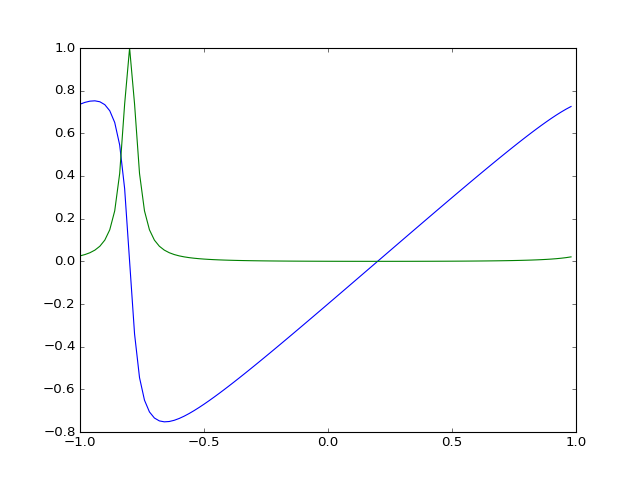

In [7]:
z = 0.9
plt.figure()
plt.plot(y,np.roll(Y(y,Ly,zeta=z),10))
plt.plot(y,np.roll(Z(y,Ly,zeta=z),10))

#plt.plot(y,Y(y,Ly,zeta=z))
#plt.plot(y,Z(y,Ly,zeta=z))

In [8]:
theta = np.linspace(-np.pi,np.pi,1000,endpoint=False)

<IPython.core.display.Javascript object>


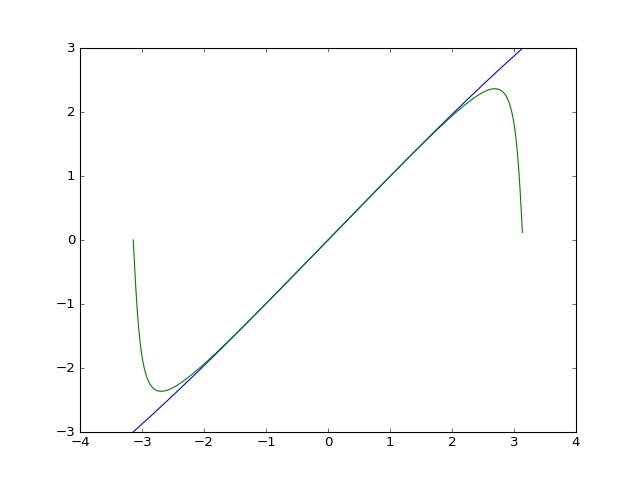

In [9]:
plt.figure()
#plt.plot(theta,np.roll(Theta_analytic(theta,zeta=0.9),100))
plt.plot(theta,Theta_approx(theta,zeta=0.9))
plt.plot(theta,Theta(theta,zeta=0.9))

## Beta plane

Now we use these mask functions in the $\beta$ plane shallow water equations:

$$
\partial_t u - \beta y v + c^2 \partial_x \eta = 0\\
\partial_t v + \beta y u + c^2 \partial_y \eta = 0\\
\partial_t \eta + \partial_x u + \partial_y v = 0
$$

Converting them to 

$$
\partial_t u - \beta Y(y;\zeta) v + c^2 \partial_x \eta + \gamma Z(y; \zeta) u = 0\\
\partial_t v + \beta Y(y;\zeta) u + c^2 \partial_y \eta + \gamma Z(y; \zeta) v = 0\\
\partial_t \eta + \partial_x u + \partial_y v = 0
$$

In [10]:
Lx = 4.
Ly = 2.
beta = 1.
gamma = 0.1
nu = 0.1

In [11]:
# bases
x_basis = de.Fourier('x', 128, interval=(0,Lx), dealias=3/2)
y_basis = de.Fourier('y', 128, interval=(-Ly, Ly), dealias=3/2)
domain = de.Domain([y_basis,x_basis], grid_dtype=np.float64)

In [12]:
bp = de.IVP(domain,variables=['u','v','eta','ytest'])
bp.parameters['beta'] = beta
bp.parameters['gamma'] = gamma
bp.parameters['zeta'] = 0.9
bp.parameters['Ly'] = Ly
bp.parameters['pi'] = np.pi
bp.parameters['nu'] = nu
bp.substitutions['theta'] = "pi*y/Ly"
bp.substitutions['Y(y)'] = "Ly/pi *((1+zeta)/zeta * arctan(zeta*sin(theta)/(1+zeta*cos(theta))))"
bp.substitutions['Z(y)'] = "(1-zeta)**2/2 * (1-cos(theta))/(1+zeta**2+2*zeta*cos(theta))"

In [13]:
bp.add_equation("dt(u) + dx(eta) - nu*(dx(dx(u)) + dy(dy(u))) = beta*Y(y)*v - gamma*Z(y)*u")
bp.add_equation("dt(v) + dy(eta) - nu*(dx(dx(v)) + dy(dy(v)))= -beta*Y(y)*u - gamma*Z(y)*v")
bp.add_equation("dt(eta) + dx(u) + dy(v) = 0")
bp.add_equation('ytest = Y(y)')

In [14]:
def filter_field(field,frac=0.5):
    dom = field.domain
    local_slice = dom.dist.coeff_layout.slices(scales=dom.dealias)
    coeff = []
    for i in range(dom.dim)[::-1]:
        coeff.append(np.linspace(0,1,dom.global_coeff_shape[i],endpoint=False))
    cc = np.meshgrid(*coeff)
    
    field_filter = np.zeros(dom.local_coeff_shape,dtype='bool')
    for i in range(dom.dim):
        field_filter = field_filter | (cc[i][local_slice] > frac)
    field['c'][field_filter] = 0j

In [15]:
dt = 0.01

ts = de.timesteppers.RK443
IVP = bp.build_solver(ts)
IVP.stop_sim_time = 15.
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 2 #10000000

2016-11-15 20:22:27,565 pencil 0/1 INFO :: Building pencil matrix 1/64 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.7e+01/s
2016-11-15 20:22:27,886 pencil 0/1 INFO :: Building pencil matrix 7/64 (~11%) Elapsed: 0s, Remaining: 3s, Rate: 1.8e+01/s
2016-11-15 20:22:28,253 pencil 0/1 INFO :: Building pencil matrix 14/64 (~22%) Elapsed: 1s, Remaining: 3s, Rate: 1.9e+01/s
2016-11-15 20:22:28,616 pencil 0/1 INFO :: Building pencil matrix 21/64 (~33%) Elapsed: 1s, Remaining: 2s, Rate: 1.9e+01/s
2016-11-15 20:22:28,983 pencil 0/1 INFO :: Building pencil matrix 28/64 (~44%) Elapsed: 1s, Remaining: 2s, Rate: 1.9e+01/s
2016-11-15 20:22:29,342 pencil 0/1 INFO :: Building pencil matrix 35/64 (~55%) Elapsed: 2s, Remaining: 2s, Rate: 1.9e+01/s
2016-11-15 20:22:29,699 pencil 0/1 INFO :: Building pencil matrix 42/64 (~66%) Elapsed: 2s, Remaining: 1s, Rate: 1.9e+01/s
2016-11-15 20:22:30,057 pencil 0/1 INFO :: Building pencil matrix 49/64 (~77%) Elapsed: 3s, Remaining: 1s, Rate: 1.9e+01/s
2016-11-15 20:22:30

In [16]:
eta = IVP.state['eta']

In [17]:
eta['g'] = np.random.randn(*eta['g'].shape)
filter_field(eta)

<IPython.core.display.Javascript object>


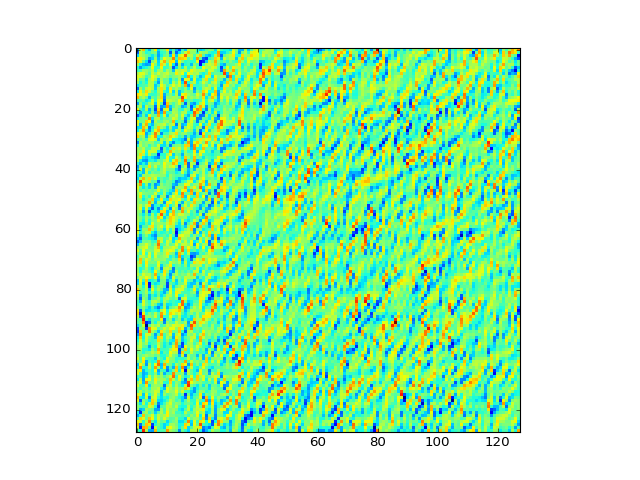

In [18]:
plt.figure()
plt.imshow(eta['g'],interpolation='none')

In [20]:
#dt = CFL.compute_dt()
# Main loop
#start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    #if IVP.iteration % 10 == 0:
    #    logger.info('Iteration: %i, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time, dt))
    #dt = CFL.compute_dt()

2016-11-15 20:22:35,261 solvers 0/1 INFO :: Stop iteration reached.


<IPython.core.display.Javascript object>


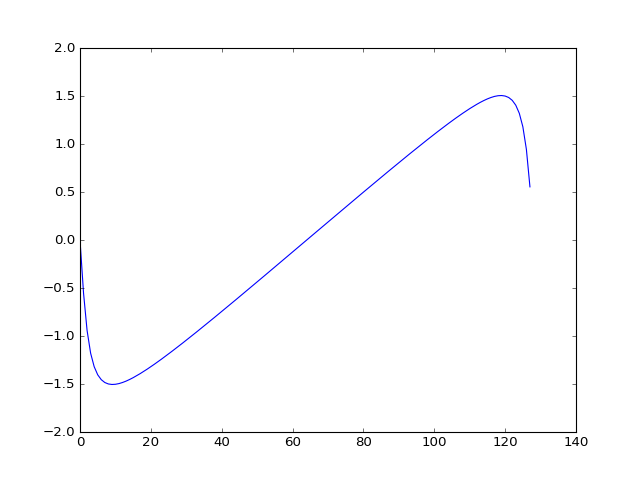

In [21]:
plt.figure()
plt.plot(IVP.state['ytest']['g'][:,0])

<IPython.core.display.Javascript object>


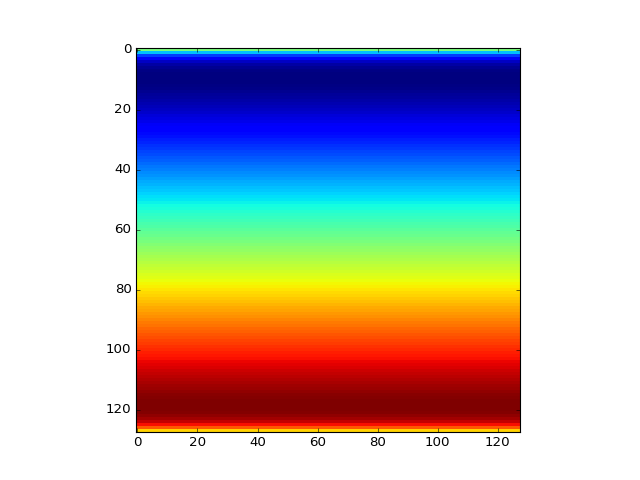

In [22]:
plt.figure()
plt.imshow(IVP.state['ytest']['g'],interpolation='none')

In [ ]:
eta_final = IVP.state['eta']

In [ ]:
plt.figure()
plt.imshow(eta['g'],interpolation='none')
plt.contour(eta['g'])

In [ ]:
IVP.stop_sim_time = 16.
while IVP.ok:
    IVP.step(dt)

In [ ]:
eta_more_final = IVP.state['eta']

In [ ]:
plt.figure()
plt.imshow(eta_more_final['g'],interpolation='none')

In [ ]:
IVP.stop_sim_time = 17.
while IVP.ok:
    IVP.step(dt)

In [ ]:
eta_more_final = IVP.state['eta']
plt.figure()
plt.imshow(eta_more_final['g'],interpolation='none')